# Employment Scam Aegean Dataset

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
df = pd.read_csv("fake_job_postings.csv",index_col='job_id')

In [3]:
for i, header in enumerate(df.columns,start=1):
    print(f'{i}. {header}')

1. title
2. location
3. department
4. salary_range
5. company_profile
6. description
7. requirements
8. benefits
9. telecommuting
10. has_company_logo
11. has_questions
12. employment_type
13. required_experience
14. required_education
15. industry
16. function
17. fraudulent


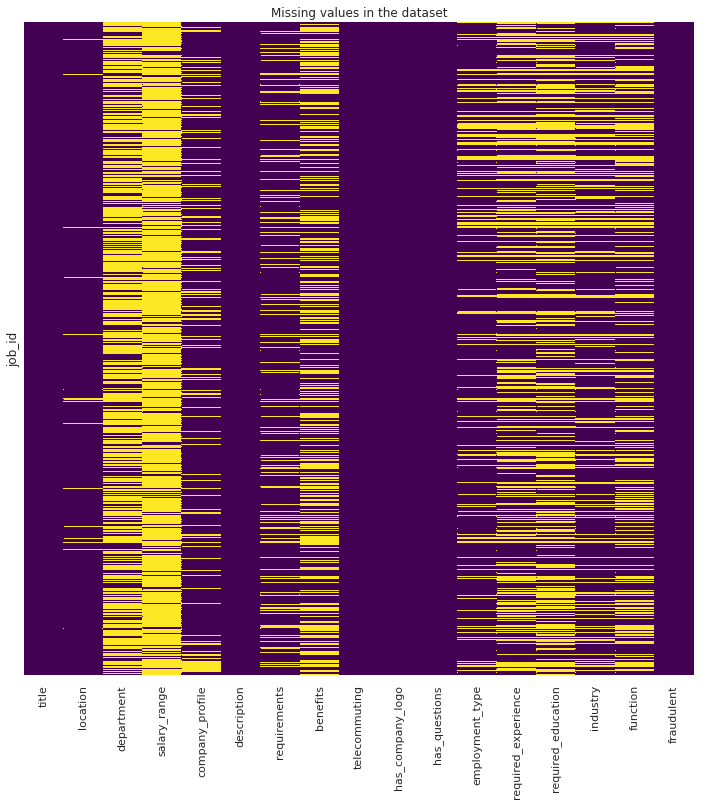

In [85]:
sns.heatmap(df.isnull(), yticklabels=False, cbar = False, cmap = 'viridis',);
plt.title('Missing values in the dataset');

866


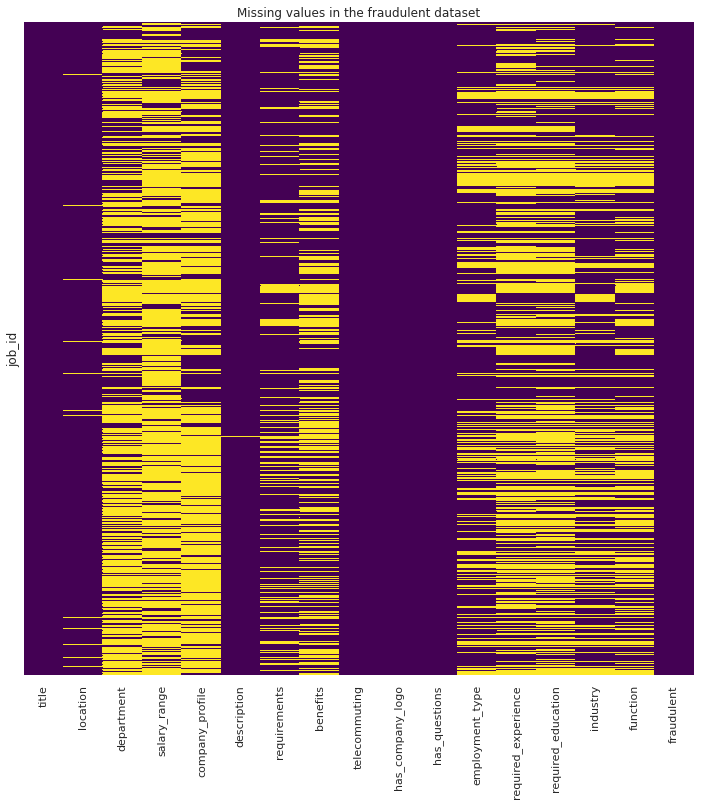

In [88]:
dffraud = df[df['fraudulent']==1]
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar = False, cmap = 'viridis',);
plt.title('Missing values in the fraudulent dataset');

It seems like the fraudsters are struggling with the company profiles...

In [54]:
_na = pd.DataFrame(index=['HasValue','IsNA'])
for header in df.columns:
    _na[header] = df[header].isna().value_counts()[0]
_na.loc['IsNA'] = 17880 - _na.loc['HasValue']

In [56]:
_na

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
HasValue,17880,17534,6333,2868,14572,17879,15185,10670,17880,17880,17880,14409,10830,9775,12977,11425,17880
IsNA,0,346,11547,15012,3308,1,2695,7210,0,0,0,3471,7050,8105,4903,6455,0


In [67]:
df[df['department'].isna()==True]

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17872,Water Truck Driver,"US, PA, Waynesburg",NaN,NaN,Valor Services provides Workforce Solutions th...,Requires skilled work in operating commercial ...,GED or diploma required.Requires minimum of on...,NaN,0,1,1,Full-time,NaN,NaN,Oil & Energy,NaN,0
17874,Recruiting Coordinator,"US, NC, Charlotte",NaN,NaN,NaN,RESPONSIBILITIES:Will facilitate the recruitin...,REQUIRED SKILLS:Associates Degree or a combina...,NaN,0,1,0,Contract,NaN,NaN,Utilities,NaN,0
17875,JavaScript Developer,"US, ,",NaN,80000-100000,NaN,"Sr, JavaScript Developer Experience : 4-10 yea...",NaN,NaN,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Information Technology,0


### Insights
This dataset contains 17880 jobs and a maximum of 16 characteristics are given to each jobs.
All jobs entry have manually been assigned a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers being flagged as legitimate whilst 866 have been flagged as fraudulent.
_Note:This assignment was done manually and errors might have occured._

The only job without a description (`df[df['description'].isna()==True]`) is a fraudulent post: Office manager in Warsaw, PL)

In [26]:
set(df['location'])

{nan,
 'CA, ON, Greater Toronto Area',
 'US, DC, ',
 'US, IL, Rockford',
 'US, WI, Mundelein',
 'US, , St. Cloud',
 'US, CO, Fort Collins',
 'US, CA, State Wide',
 'MU, QB, Ebene',
 'US, MN, Twin Cities',
 'IQ, , Erbil',
 'US, SC, Charlotte',
 'US, ND, ',
 'GB, LND, EC4M 7AN',
 'LU, , Work from home',
 'US, ME, Orono',
 'DK, , Ballerup ',
 'CL, RM, Santiago',
 'CH, ZH, ',
 'FI, , Turku',
 'GR, I, Penteli',
 'US, CT, New Haven',
 'GB, , See the Requirements section for areas and locations available',
 'US, TX, DFW',
 'US, CA, San Francisco Bay Area ',
 'US, TX, Allen',
 'US, IL, Illinois',
 'US, NJ, Hillside, NJ',
 'US, AZ, Tucson',
 'EE, 37, Tallinn',
 'NZ',
 'US, GA, ',
 'BY, HM, Minsk',
 'BE, BRU, Auderghem',
 'NG, LA, ',
 'GB, WSM, London',
 'US, NY, ',
 'US, CO, Egnar',
 'GB, NYK, Thirsk',
 'PH, , Makati City ',
 'US, TX, AUS/SAT',
 'IT, 52, Florence',
 'US, TN, Chattanooga',
 'US, OH, Oberlin',
 'US, AZ, ',
 'IN, RJ, Jaipur',
 'IN, MP, indore',
 'DK, 84, Copenhagen',
 'US, WI, Jac

Location: remove `\t`, expect postcodes,'See the Requirements section for areas and locations available', greek characters, 'Silicon Valley/San Jose\xa0-\xa0Santa Clara', 'Work from home', accents (Quebec), multiple locations (Amsterdam, Rotterdam, The Hague, Utrecht)

Location needs to be consolidated (there a a couple of the same city with different county, etc.)

In [66]:
df[df['location']=='US, CA, BERKELY ']

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
5188,Sales - Sports Advertising Sales,"US, CA, BERKELY",SALES,NaN,Campus Concepts we are a National Sports Marke...,Sales- Sports Advertising - Closers Only Sport...,NaN,NaN,1,1,0,Full-time,Mid-Senior level,NaN,Marketing and Advertising,Sales,0
